In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import chi2_contingency, ttest_1samp, f_oneway, pearsonr

1. Import claims_data.csv and cust_data.csv which is provided to you and combine the two datasets appropriately to create a 360-degree view of the data. Use the same for the subsequent questions.

In [4]:
# Read the claims_data.csv and cust_data.csv files
claims_data = pd.read_csv('claims.csv')
cust_data = pd.read_csv('cust_demographics.csv')

# Combine the datasets based on the customer_id column
combined_data = pd.merge(cust_data, claims_data, left_on='CUST_ID', right_on='customer_id', how='inner')

# Print the combined dataset
print(combined_data)

       CUST_ID  gender DateOfBirth State       Contact   Segment  claim_id  \
0     21868593  Female   12-Jan-79    VT  789-916-8172  Platinum  54004764   
1     75740424  Female   13-Jan-70    ME  265-543-1264    Silver  33985796   
2     30308357  Female   11-Mar-84    TN  798-631-4758    Silver  53522022   
3     30308357  Female   11-Mar-84    TN  798-631-4758    Silver  63017412   
4     47830476  Female   01-May-86    MA  413-187-7945    Silver  13015401   
...        ...     ...         ...   ...           ...       ...       ...   
1080  79539873  Female   15-Mar-81    ND  459-425-4319  Platinum  62020796   
1081  42364152  Female   07-Jul-96    ID  529-462-1635    Silver  63269067   
1082  19888166    Male   11-Apr-90    WI  712-651-9613      Gold  22690595   
1083  11256802  Female   22-Oct-64    LA  469-345-5617    Silver  12376894   
1084  61575264    Male   12-Jul-95    WY  182-385-1392      Gold  63226031   

      customer_id      incident_cause  claim_date claim_area po

2. Perform a data audit for the datatypes and find out if there are any mismatch within the current datatypes of the columns and their business significance

In [5]:
# Check the datatypes of the columns
print(combined_data.dtypes)

# Perform data audit for datatype and business significance
data_audit = pd.DataFrame({
    'Column': combined_data.columns,
    'Datatype': combined_data.dtypes,
    'Business Significance': ['Customer ID', 'Gender', 'Date of Birth', 'State', 'Contact', 'Segment',
                              'Claim ID', 'Customer ID', 'Incident Cause', 'Claim Date', 'Claim Area',
                              'Police Report', 'Claim Type', 'Claim Amount', 'Total Policy Claims', 'Fraudulent']
})

# Print the data audit summary
print(data_audit)

CUST_ID                  int64
gender                  object
DateOfBirth             object
State                   object
Contact                 object
Segment                 object
claim_id                 int64
customer_id              int64
incident_cause          object
claim_date              object
claim_area              object
police_report           object
claim_type              object
claim_amount            object
total_policy_claims    float64
fraudulent              object
dtype: object
                                  Column Datatype Business Significance
CUST_ID                          CUST_ID    int64           Customer ID
gender                            gender   object                Gender
DateOfBirth                  DateOfBirth   object         Date of Birth
State                              State   object                 State
Contact                          Contact   object               Contact
Segment                          Segment   object         

3. Convert the column claim_amount to numeric. Use the appropriate modules/attributes to remove the $ sign.

In [6]:
# Remove the '$' sign and convert to numeric
combined_data['claim_amount'] = combined_data['claim_amount'].str.replace('$', '').astype(float)

# Verify the changes
print(combined_data['claim_amount'].head())
print(combined_data['claim_amount'].dtypes)

0    2980.0
1    2980.0
2    3369.5
3    1950.0
4    1680.0
Name: claim_amount, dtype: float64
float64


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10416\3466937738.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  combined_data['claim_amount'] = combined_data['claim_amount'].str.replace('$', '').astype(float)


4. Of all the injury claims, some of them have gone unreported with the police. Create an alert flag (1,0) for all such claims

In [7]:
# Create an alert flag for unreported injury claims
combined_data['unreported_injury_flag'] = np.where((combined_data['claim_type'] == 'Injury only') & (combined_data['police_report'] == 'No'), 1, 0)

# Verify the changes
print(combined_data[['claim_type', 'police_report', 'unreported_injury_flag']].head())

      claim_type police_report  unreported_injury_flag
0  Material only            No                       0
1  Material only       Unknown                       0
2  Material only            No                       0
3  Material only            No                       0
4  Material only            No                       0


5. One customer can claim for insurance more than once and in each claim, multiple categories of claims can be involved. However, customer ID should remain unique. Retain the most recent observation and delete any duplicated records in the data based on the customer ID column.

In [8]:
# Sort the data by customer ID and claim_date in descending order
combined_data.sort_values(by=['customer_id', 'claim_date'], ascending=[True, False], inplace=True)

# Drop duplicated records based on customer ID, keeping only the first occurrence (most recent)
combined_data.drop_duplicates(subset='customer_id', keep='first', inplace=True)

# Verify the changes
print(combined_data.head())

     CUST_ID  gender DateOfBirth State       Contact   Segment  claim_id  \
188   154557  Female   23-May-78    DE  962-879-1238  Platinum  69348631   
836   263204    Male   20-Dec-72    TX  173-892-6314    Silver  40953049   
677   287476    Male   28-Jul-88    FL  364-598-1549    Silver  45780237   
828   441097    Male   19-Aug-71    CA  187-348-8375      Gold  89833962   
509   524545  Female   10-Aug-80    NC  798-862-5398      Gold  35782742   

     customer_id      incident_cause  claim_date claim_area police_report  \
188       154557        Driver error  04/10/2018       Auto            No   
836       263204        Other causes  04/04/2018       Auto            No   
677       287476      Natural causes  10/17/2017       Auto       Unknown   
828       441097        Other causes  03/21/2018       Auto           Yes   
509       524545  Other driver error  07/27/2018       Auto            No   

              claim_type  claim_amount  total_policy_claims fraudulent  \
188   

6. Check for missing values and impute the missing values with an appropriate value. (mean for continuous and mode for categorical)

In [9]:
# Check for missing values
missing_values = combined_data.isnull().sum()
print(missing_values)

# Impute missing values
combined_data['claim_amount'] = combined_data['claim_amount'].fillna(combined_data['claim_amount'].mean())
combined_data['police_report'] = combined_data['police_report'].fillna(combined_data['police_report'].mode()[0])

# Verify the changes
print(combined_data.head())

CUST_ID                    0
gender                     0
DateOfBirth                0
State                      0
Contact                    0
Segment                    0
claim_id                   0
customer_id                0
incident_cause             0
claim_date                 0
claim_area                 0
police_report              0
claim_type                 0
claim_amount              65
total_policy_claims       10
fraudulent                 0
unreported_injury_flag     0
dtype: int64
     CUST_ID  gender DateOfBirth State       Contact   Segment  claim_id  \
188   154557  Female   23-May-78    DE  962-879-1238  Platinum  69348631   
836   263204    Male   20-Dec-72    TX  173-892-6314    Silver  40953049   
677   287476    Male   28-Jul-88    FL  364-598-1549    Silver  45780237   
828   441097    Male   19-Aug-71    CA  187-348-8375      Gold  89833962   
509   524545  Female   10-Aug-80    NC  798-862-5398      Gold  35782742   

     customer_id      incident_cause 

7. Calculate the age of customers in years. Based on the age, categorize the customers according to the below criteria
Children < 18
Youth 18-30
Adult 30-60
Senior > 60

In [12]:
# Calculate age in years
current_year = datetime.datetime.now().year
cust_data['DateOfBirth'] = pd.to_datetime(cust_data['DateOfBirth'])
cust_data['Age'] = current_year - cust_data['DateOfBirth'].dt.year

# Categorize customers based on age
cust_data['Age_Category'] = pd.cut(cust_data['Age'], bins=[0, 18, 30, 60, float('inf')], labels=['Children', 'Youth', 'Adult', 'Senior'])

# Display the updated dataframe
print(cust_data.head())

    CUST_ID  gender DateOfBirth State       Contact   Segment  Age  \
0  21868593  Female  1979-01-12    VT  789-916-8172  Platinum   44   
1  75740424  Female  2070-01-13    ME  265-543-1264    Silver  -47   
2  30308357  Female  1984-03-11    TN  798-631-4758    Silver   39   
3  47830476  Female  1986-05-01    MA  413-187-7945    Silver   37   
4  19269962    Male  1977-05-13    NV  956-871-8691      Gold   46   

  Age_Category  
0        Adult  
1          NaN  
2        Adult  
3        Adult  
4        Adult  


8. What is the average amount claimed by the customers from various segments?

In [14]:
average_claim_amount = combined_data.groupby('Segment')['claim_amount'].mean()
print(average_claim_amount)

Segment
Gold        12788.392275
Platinum    12370.790860
Silver      12266.176689
Name: claim_amount, dtype: float64


9. What is the total claim amount based on incident cause for all the claims that have been done at least 20 days prior to 1st of October, 2018.

In [20]:
# Convert 'claim_date' to datetime
combined_data['claim_date'] = pd.to_datetime(combined_data['claim_date'])

# Filter claims that have a claim date at least 20 days prior to 1st of October, 2018
filtered_claims = combined_data[combined_data['claim_date'] <= pd.to_datetime('2018-09-11')]

# Group by incident cause and calculate the sum of claim amounts
total_claim_amounts = filtered_claims.groupby('incident_cause')['claim_amount'].sum()

# Format the claim amounts in currency format
total_claim_amounts_formatted = total_claim_amounts.apply(lambda x: '${:,.2f}'.format(x))

print(total_claim_amounts_formatted)

incident_cause
Crime                   $721,834.67
Driver error          $3,278,791.20
Natural causes        $1,312,799.90
Other causes          $3,725,236.73
Other driver error    $3,315,572.63
Name: claim_amount, dtype: object


10. How many adults from TX, DE and AK claimed insurance for driver related issues and causes?

In [22]:
current_year = datetime.datetime.now().year
combined_data['DateOfBirth'] = pd.to_datetime(combined_data['DateOfBirth'])
combined_data['Age'] = current_year - combined_data['DateOfBirth'].dt.year

# Filter the data for driver-related issues and causes
driver_related_claims = combined_data[combined_data['incident_cause'].str.contains('driver', case=False)]

# Filter the driver-related claims for the states TX, DE, and AK
filtered_claims = driver_related_claims[driver_related_claims['State'].isin(['TX', 'DE', 'AK'])]

# Filter the claims for adults (age >= 30 and age <= 60)
adult_claims = filtered_claims[(filtered_claims['Age'] >= 30) & (filtered_claims['Age'] <= 60)]

# Count the number of unique customers
num_adults_claimed = adult_claims['CUST_ID'].nunique()

print("Number of adults from TX, DE, and AK who claimed insurance for driver-related issues and causes:", num_adults_claimed)


Number of adults from TX, DE, and AK who claimed insurance for driver-related issues and causes: 21


11. Draw a pie chart between the aggregated value of claim amount based on gender and segment. Represent the claim amount as a percentage on the pie chart.

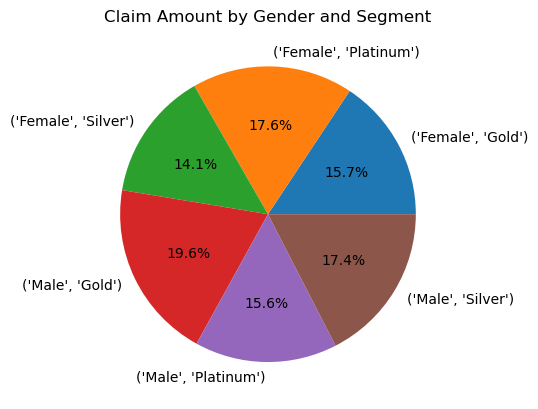

In [23]:
# Group the data by gender and segment and calculate the sum of claim amounts
grouped_data = combined_data.groupby(['gender', 'Segment'])['claim_amount'].sum()

# Calculate the percentage of claim amounts for each group
total_claim_amount = grouped_data.sum()
claim_amount_percentage = (grouped_data / total_claim_amount) * 100

# Create a pie chart
fig, ax = plt.subplots()
ax.pie(claim_amount_percentage, labels=claim_amount_percentage.index, autopct='%1.1f%%')
ax.set_aspect('equal')  # Ensure the pie is drawn as a circle
ax.set_title('Claim Amount by Gender and Segment')

# Display the pie chart
plt.show()

12. Among males and females, which gender had claimed the most for any type of driver related issues? E.g. This metric can be compared using a bar chart

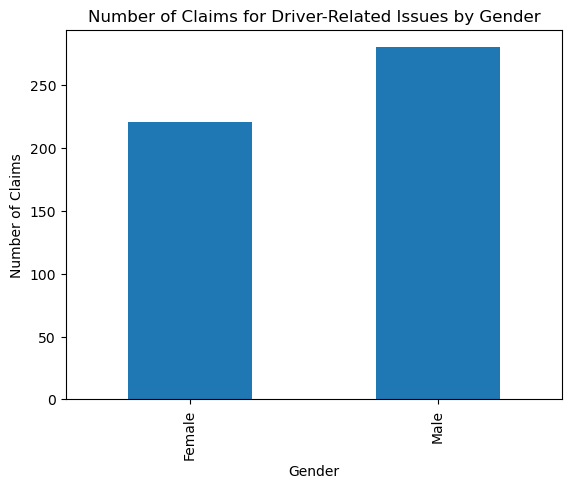

In [24]:
# Filter the data for driver-related issues
driver_related_claims = combined_data[combined_data['incident_cause'].str.contains('driver', case=False)]

# Group the data by gender and count the number of claims
gender_claims = driver_related_claims.groupby('gender').size()

# Create a bar chart
fig, ax = plt.subplots()
gender_claims.plot(kind='bar', ax=ax)
ax.set_xlabel('Gender')
ax.set_ylabel('Number of Claims')
ax.set_title('Number of Claims for Driver-Related Issues by Gender')

# Display the bar chart
plt.show()

13. Which age group had the maximum fraudulent policy claims? Visualize it on a bar chart.

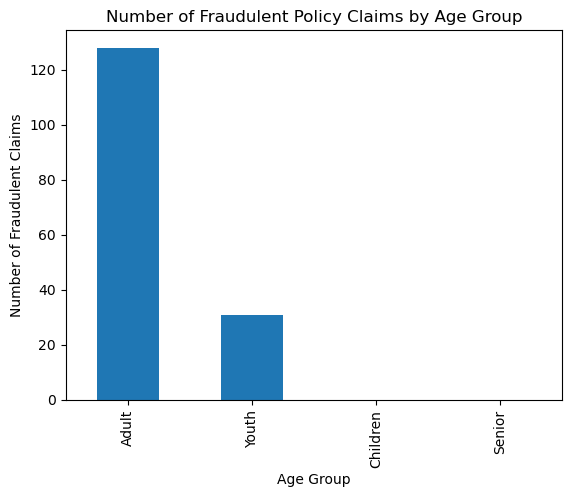

In [27]:
# Define age groups
age_groups = ['Children', 'Youth', 'Adult', 'Senior']
age_bins = [0, 17, 30, 60, 100]
combined_data['AgeGroup'] = pd.cut(combined_data['Age'], bins=age_bins, labels=age_groups, right=False)

# Filter the data for fraudulent policy claims
fraudulent_claims = combined_data[combined_data['fraudulent'] == 'Yes']

# Group the data by age group and count the number of fraudulent claims
age_group_fraudulent_claims = fraudulent_claims['AgeGroup'].value_counts()

# Create a bar chart
fig, ax = plt.subplots()
age_group_fraudulent_claims.plot(kind='bar', ax=ax)
ax.set_xlabel('Age Group')
ax.set_ylabel('Number of Fraudulent Claims')
ax.set_title('Number of Fraudulent Policy Claims by Age Group')

# Display the bar chart
plt.show()

14. Visualize the monthly trend of the total amount that has been claimed by the customers. Ensure that on the “month” axis, the month is in a chronological order not alphabetical order.

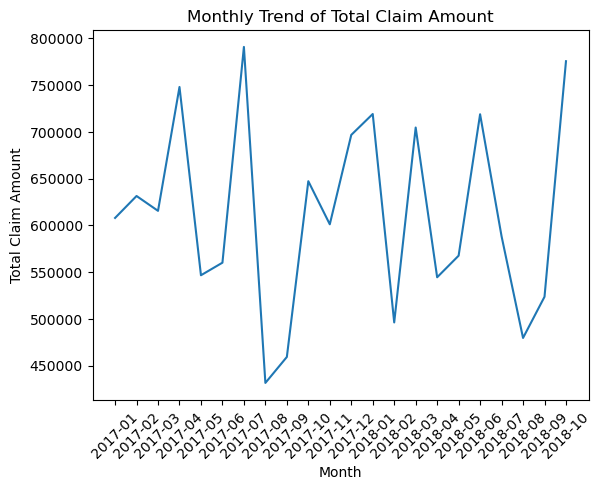

In [29]:
# Convert the Period index to strings
monthly_total_claim_amount.index = monthly_total_claim_amount.index.astype(str)

# Sort the index in chronological order
monthly_total_claim_amount = monthly_total_claim_amount.sort_index()

# Plot the data using a line plot
plt.plot(monthly_total_claim_amount.index, monthly_total_claim_amount.values)
plt.xlabel('Month')
plt.ylabel('Total Claim Amount')
plt.title('Monthly Trend of Total Claim Amount')
plt.xticks(rotation=45)
plt.show()

15. What is the average claim amount for gender and age categories and suitably represent the above using a facetted bar chart, one facet that represents fraudulent claims and the other for non-fraudulent claims.

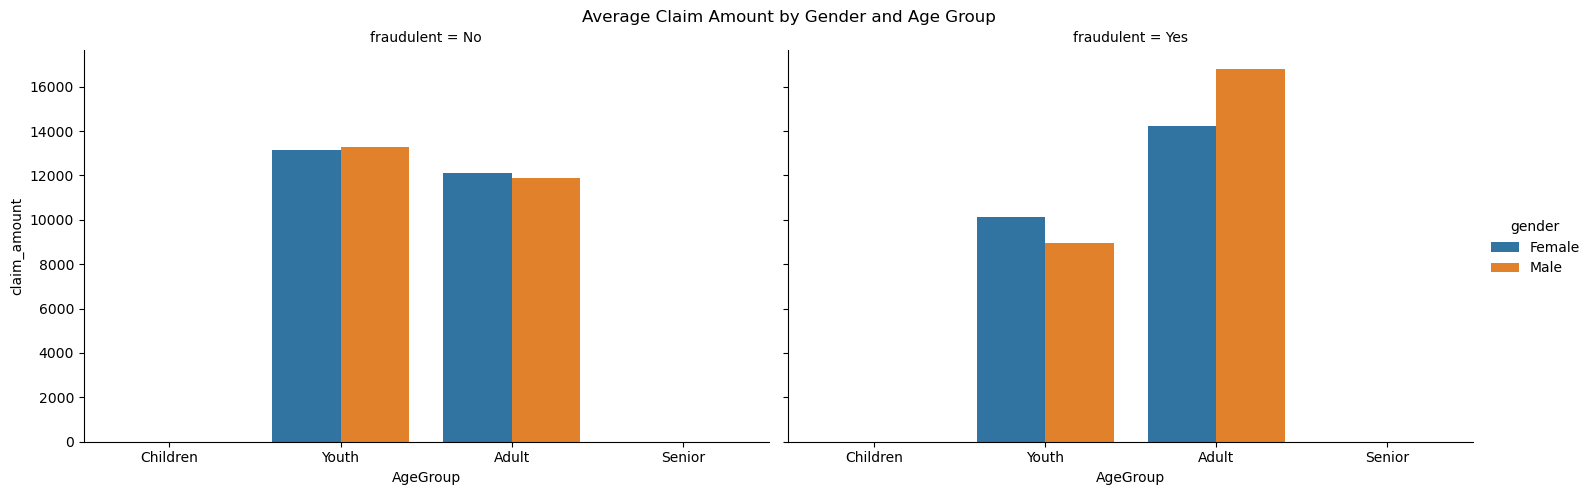

In [33]:
# Calculate the average claim amount for gender and age categories
average_claim_amount = combined_data.groupby(['gender', 'AgeGroup', 'fraudulent'])['claim_amount'].mean().reset_index()

# Create a facetted bar chart
sns.catplot(x='AgeGroup', y='claim_amount', hue='gender', col='fraudulent', data=average_claim_amount, kind='bar', height=5, aspect=1.5)
plt.subplots_adjust(top=0.9)
plt.suptitle('Average Claim Amount by Gender and Age Group')
plt.show()

Based on the conclusions from exploratory analysis as well as suitable
statistical tests, answer the below questions. Please include a detailed
write-up on the parameters taken into consideration, the Hypothesis
testing steps, conclusion from the p-values and the business implications of
the statements.

16. Is there any similarity in the amount claimed by males and females?

In [36]:
male_claims = combined_data[combined_data['gender'] == 'Male']['claim_amount']
female_claims = combined_data[combined_data['gender'] == 'Female']['claim_amount']

# Independent t-test
t_statistic, p_value = stats.ttest_ind(male_claims, female_claims, equal_var=False)

# Mann-Whitney U test
# u_statistic, p_value = stats.mannwhitneyu(male_claims, female_claims, alternative='two-sided')

if p_value < 0.05:
    print("There is a significant difference in the amount claimed by males and females.")
else:
    print("There is no significant difference in the amount claimed by males and females.")

There is no significant difference in the amount claimed by males and females.


17. Is there any relationship between age category and segment?

In [38]:
observed = pd.crosstab(combined_data['AgeGroup'], combined_data['Segment'])
chi2, p_value, dof, expected = chi2_contingency(observed)

if p_value < 0.05:
    print("There is a significant relationship between age category and segment.")
else:
    print("There is no significant relationship between age category and segment.")

There is no significant relationship between age category and segment.


18. The current year has shown a significant rise in claim amounts as compared to 2016-17 fiscal average which was $10,000.

In [39]:
current_year_claims = combined_data[combined_data['claim_date'].dt.year == 2021]['claim_amount']

# One-sample t-test
t_statistic, p_value = ttest_1samp(current_year_claims, 10000)

if p_value < 0.05:
    print("There is a significant rise in claim amounts compared to the 2016-17 fiscal average.")
else:
    print("There is no significant rise in claim amounts compared to the 2016-17 fiscal average.")

There is no significant rise in claim amounts compared to the 2016-17 fiscal average.


C:\ProgramData\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


19. Is there any difference between age groups and insurance claims?

In [40]:
age_group1_claims = combined_data[combined_data['AgeGroup'] == 'Children']['claim_amount']
age_group2_claims = combined_data[combined_data['AgeGroup'] == 'Youth']['claim_amount']
age_group3_claims = combined_data[combined_data['AgeGroup'] == 'Adult']['claim_amount']
age_group4_claims = combined_data[combined_data['AgeGroup'] == 'Senior']['claim_amount']

# One-way ANOVA
f_statistic, p_value = f_oneway(age_group1_claims, age_group2_claims, age_group3_claims, age_group4_claims)

if p_value < 0.05:
    print("There is a significant difference in insurance claims among different age groups.")
else:
    print("There is no significant difference in insurance claims among different age groups.")

There is no significant difference in insurance claims among different age groups.


C:\ProgramData\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:3861: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '


20. Is there any relationship between total number of policy claims and the claimed amount?

In [44]:
# Drop rows with missing values in 'total_policy_claims' or 'claim_amount' column
combined_data = combined_data.dropna(subset=['total_policy_claims', 'claim_amount'])

correlation_coefficient, p_value = pearsonr( combined_data['total_policy_claims'],  combined_data['claim_amount'])

if p_value < 0.05:
    print("There is a significant relationship between the total number of policy claims and the claimed amount.")
else:
    print("There is no significant relationship between the total number of policy claims and the claimed amount.")

There is no significant relationship between the total number of policy claims and the claimed amount.
